In [70]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
import pandas_datareader.data as web
import talib
import numpy as np
import pandas as pd
import datetime

In [73]:
start = datetime.datetime(2018, 7, 1) # 指定开始时间
end = datetime.datetime.now() # 指定结束时间
print(start, end)
code = '002588.SZ' # 史丹利
code = '600178.SS' # 安东动力
code = '000725.SZ' # 京东方A(SZ:000725)
code = '002830.SZ' # 名雕股份(SZ:002830)
# code = '603187.SS'

# 获取股票数据
stock_data = web.DataReader(code, 'yahoo', start, end)
# print(stock_data)
# print(SS600036)
stock_data.to_csv("ipynb_data/{}.csv".format(code))
df = pd.read_csv("ipynb_data/{}.csv".format(code))
df.info()
df.tail(10)

2018-07-01 00:00:00 2020-08-03 16:43:04.450817
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       507 non-null    object 
 1   High       507 non-null    float64
 2   Low        507 non-null    float64
 3   Open       507 non-null    float64
 4   Close      507 non-null    float64
 5   Volume     507 non-null    float64
 6   Adj Close  507 non-null    float64
dtypes: float64(6), object(1)
memory usage: 27.9+ KB


,Date,High,Low,Open,Close,Volume,Adj Close
497,2020-07-21,13.73,12.90,12.92,13.44,3026751.0,13.44
498,2020-07-22,14.09,13.15,13.27,13.41,5197969.0,13.41
499,2020-07-23,13.75,13.00,13.40,13.59,3465700.0,13.59
500,2020-07-24,13.75,13.06,13.48,13.19,2133800.0,13.19
501,2020-07-27,13.33,12.72,13.30,12.83,1421200.0,12.83
502,2020-07-28,14.16,12.70,12.80,14.16,7358700.0,14.16
503,2020-07-29,15.54,13.26,13.56,15.16,12982657.0,15.16
504,2020-07-30,16.00,14.12,14.25,14.19,12418673.0,14.19
505,2020-07-31,13.96,13.29,13.65,13.59,6261634.0,13.59
506,2020-08-03,14.09,13.43,13.52,13.95,5197465.0,13.95


In [74]:
df.isnull().values.sum()

0

In [75]:
#计算跌涨幅
df['Range'] = df['Close']  - df['Close'].shift(1)

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']
#⽤来正常显示中⽂标签
plt.rcParams['axes.unicode_minus']=False 
#⽤来正常显示负号 #有中⽂出现的情况，需要u'内容'

In [77]:
#调整数据索引
df.index = df.Date
df  =  df[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Range']]

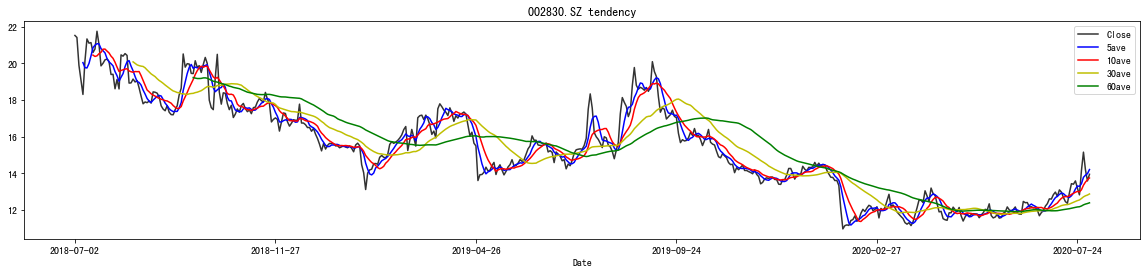

In [104]:
#简单查看股票价格走势图
df['Close'].plot(figsize=(20,4),
                 color = 'black',
                 alpha = 0.8,
                 grid = True,
                 rot = 0,
                 title='{} tendency'.format(code))
#绘制移动平均线
df['Close'].rolling(window=5).mean().plot(c='b')
df['Close'].rolling(window=10).mean().plot(c='r')
df['Close'].rolling(window=30).mean().plot(c='y')
df['Close'].rolling(window=60).mean().plot(c='g')
plt.legend(['Close','5ave','10ave','30ave','60ave'],loc='best')
plt.show()

<AxesSubplot:xlabel='Date'>

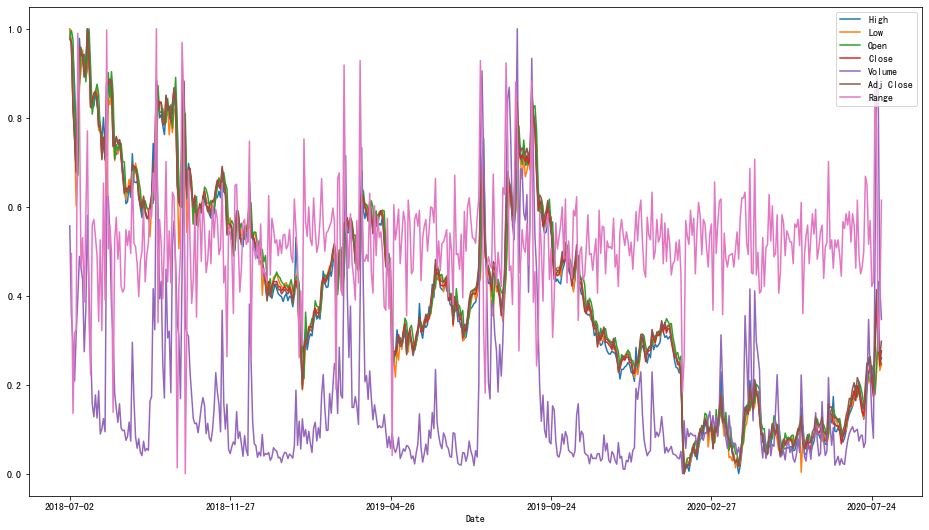

In [107]:
'''
    Min-Max 标准化是最常用的规范化手段
'''
df_min_max = (df - df.min()) / (df.max() - df.min())
df_min_max.plot(figsize=(16, 9))

In [111]:
import pyecharts as pe

# 均线
df['Ma5'] = df.Close.rolling(window=5).mean()  
df['Ma10'] = df.Close.rolling(window=10).mean()
# df['Ma20'] = df.Close.rolling(window=20).mean()
# df['Ma30'] = df.Close.rolling(window=30).mean()
# df['Ma60'] = df.Close.rolling(window=60).mean()
upper,middle,lower = talib.BBANDS(df.Close,matype=talib.MA_Type.T3)

# print(upper,middle,lower)
# print(df.tail())  # 查看前几行
# print(df.columns)  # 查看列名
# print(df.index)  # 查看索引
# print(df.describe())  # 查看各列数据描述性统计

kline = pe.Kline("{}".format(code),title_pos="40%")
ohlc = list(zip(df.Open,df.Close,df.Low,df.High))
dates = df.index

#is_datazoom_show=True 图表数据缩放  指定 markLine 位于开盘或者收盘上
kline.add("日K", dates, ohlc, 
          is_datazoom_show=True,
          is_xaxis_show=False, 
          legend_pos="85%",
          legend_orient="vertical",
          legend_top="45%",
          datazoom_range=[97,100], #设置区域缩放的范围，这里设置为末尾3%的k线数据
          is_xaxislabel_align = True,
          tooltip_trigger ='axis',
          tooltip_axispointer_type ='shadow',
          mark_line=["max"],
          mark_point=['max','min'])

line = pe.Line()
# 均线
indic_name_list = ['Ma5','Ma10']
colors = ['black', 'cyan']
for idx, indic_ma in enumerate(indic_name_list):
      line.add(indic_ma, dates, df[indic_ma].tolist(),is_smooth=True,line_width=1,line_color=colors[idx])

# 布林线
line.add('upper', dates, upper.tolist(),is_smooth=True,line_width=2,line_color='red')
line.add('middle', dates, middle.tolist(),is_smooth=True,line_width=2,line_color='blue')
line.add('lower', dates, lower.tolist(),is_smooth=True,line_width=2,line_color='green')


bar = pe.Bar()
volume_rise=[df.Volume[x] if df.Close[x] > df.Open[x] else "0" for x in range(0, len(df.index))]
volume_drop=[df.Volume[x] if df.Close[x] <= df.Open[x] else "0" for x in range(0, len(df.index))]
#is_yaxis_show=True 显示y坐标轴
#datazoom_xaxis_index=[0, 1] 设置dataZoom控制索引为 0,1两个x 轴
bar.add("rvolume", dates, volume_rise, is_stack=True)
bar.add("dvolume", dates, volume_drop, is_stack=True,legend_pos="85%",legend_orient="vertical",legend_top="30%", \
        is_datazoom_show=True,tooltip_tragger="axis", is_legend_show=True, is_yaxis_show=True, datazoom_xaxis_index=[0, 1])

# buy and sell
es = pe.EffectScatter("buy")

short_long = np.sign(df['Ma5'] - df['Ma10'])
df['bs'] = np.sign(short_long - short_long.shift(1))


for i in range(0, len(df)):
    v1 = dates[i]
    if df.iloc[i]['bs'] == 1:
        v2 = df['Low'].iloc[i]
        es.add("buy", [v1], [v2],)
    elif df.iloc[i]['bs'] == -1:
        v2 = df['High'].iloc[i]
        es.add( "sell", [v1], [v2], symbol="diamond",)


overlap = pe.Overlap(width=500, height=150)
overlap.add(kline)
overlap.add(line)
overlap.add(es)
grid = pe.Grid()
grid.add(bar, grid_top="70%",grid_right="15%")
grid.add(overlap, grid_bottom="30%",grid_right="15%")

In [112]:
#使用指标来绘制热力图
data = pd.merge(short_rolling,long_rolling,left_index=True,right_index=True)
print(data.head())

            Close_x  Close_y
Date                        
2018-07-02      NaN      NaN
2018-07-03      NaN      NaN
2018-07-04      NaN      NaN
2018-07-05      NaN      NaN
2018-07-06    20.05      NaN


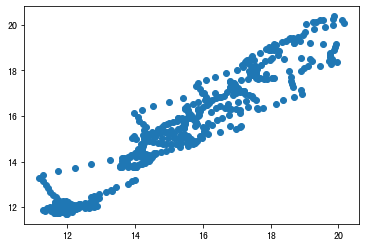

In [113]:
plt.scatter(data['Close_x'],data['Close_y'])

In [114]:
#加性模型预测Prophet
data = y2020['Close'].reset_index()
data = data.rename(columns={'Date': 'ds', 'Close': 'y'})
print(data.tail())

             ds      y
501  2020-07-27  12.83
502  2020-07-28  14.16
503  2020-07-29  15.16
504  2020-07-30  14.19
505  2020-07-31  13.59


In [115]:
import fbprophet
# growth default'linear'
# growth=logistic and must have capacity value, eg: df['cap']=100
model = fbprophet.Prophet(growth='linear', changepoint_prior_scale=0.05, daily_seasonality=True, weekly_seasonality=True) # 定义模型
model.add_seasonality(name='weekly', period=5, fourier_order=3, prior_scale=0.1)
model.fit(data) # 训练模型

In [116]:
forecast_df = model.make_future_dataframe(periods=20, freq='D') # 生成需预测序列
forecast = model.predict(forecast_df) # 模型预测

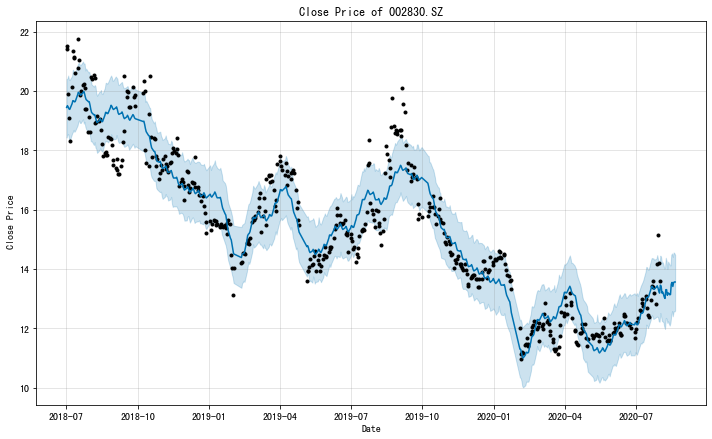

In [117]:
model.plot(forecast, xlabel = 'Date', ylabel = 'Close Price ¥'); # 绘制预测图
plt.title('Close Price of {}'.format(code));

In [118]:
def plot(m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y', plot_color='#0072B2'):
    """Plot the Prophet forecast.
    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    Returns
    -------
    A matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=(10, 6))
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c=plot_color)
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
    if uncertainty:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color=plot_color, alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig

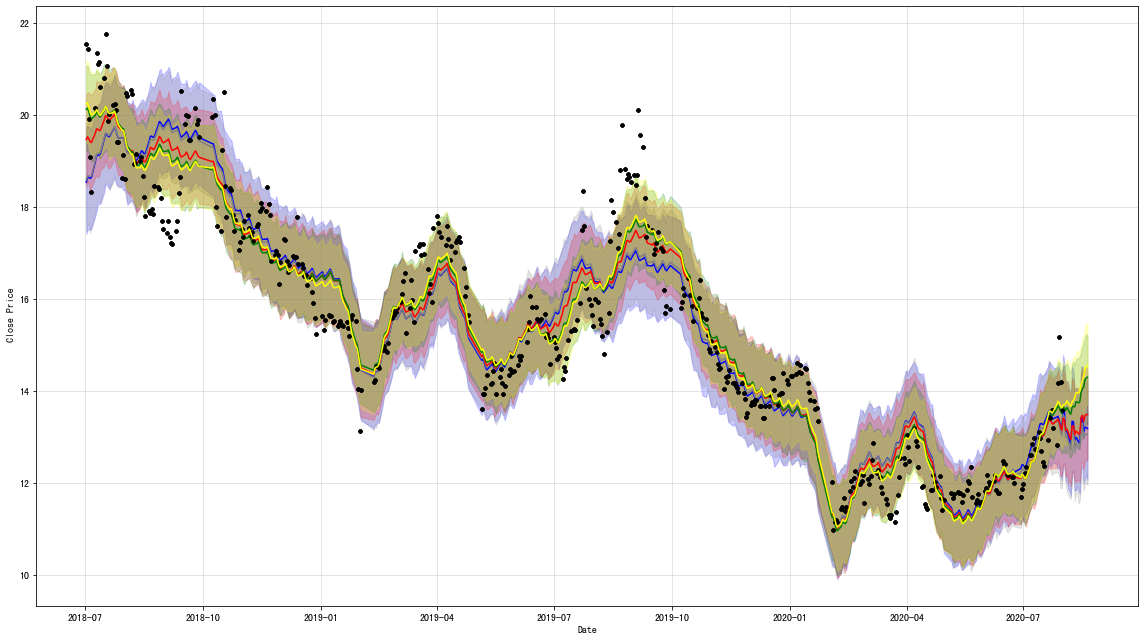

In [119]:
fig, ax = plt.subplots(figsize=(16,9))

# 此处代码运行时间较长，请耐心等待
for point, color in zip([0.01, 0.02, 0.05, 0.08, 0.1], ['blue', 'grey', 'red', 'green', 'yellow']):
    temp_model = fbprophet.Prophet(changepoint_prior_scale=point, daily_seasonality=True)
    temp_model.fit(data)
    forecast = temp_model.make_future_dataframe(periods=20, freq='D') # 20 day
    forecast = temp_model.predict(forecast)
    plot(temp_model, forecast, ax=ax, xlabel = 'Date', ylabel = 'Close Price ¥', plot_color=color);

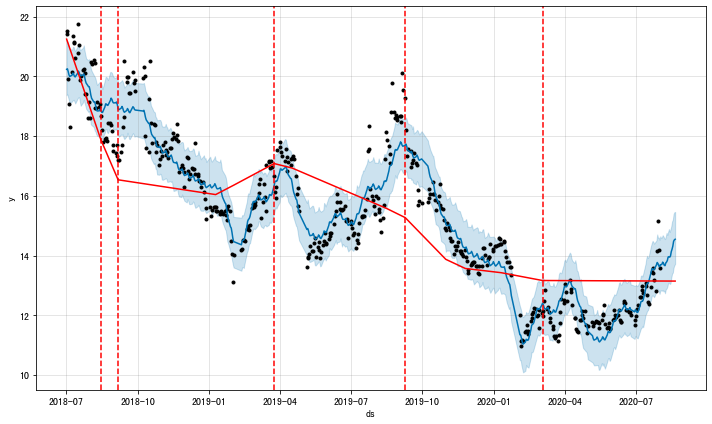

In [120]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast) # 绘制预测图
a = add_changepoints_to_plot(fig.gca(), model, forecast) # 增加变化点

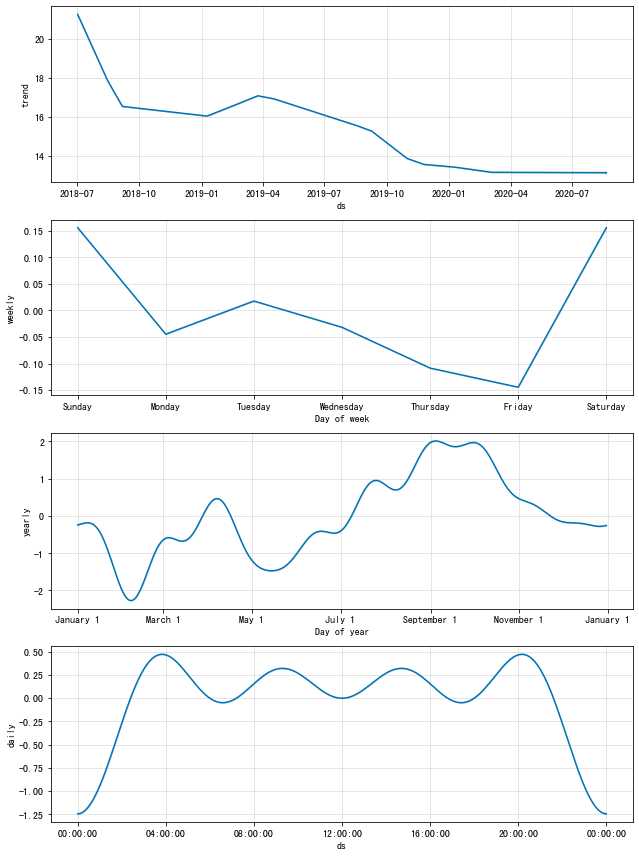

In [27]:
from fbprophet.plot import plot_components
model.plot_components(forecast); # 绘制多维度变化趋势图

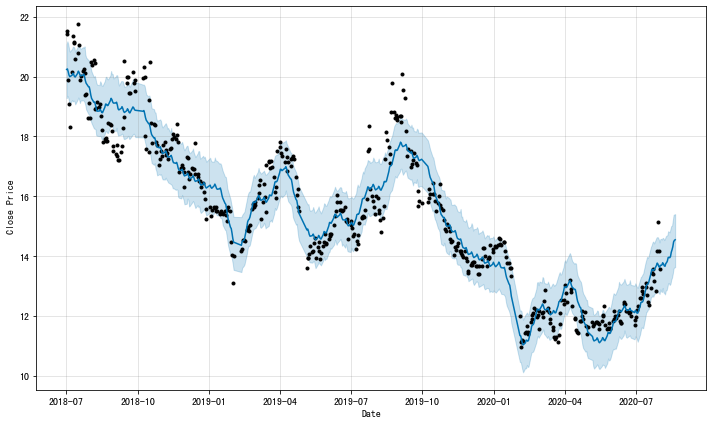

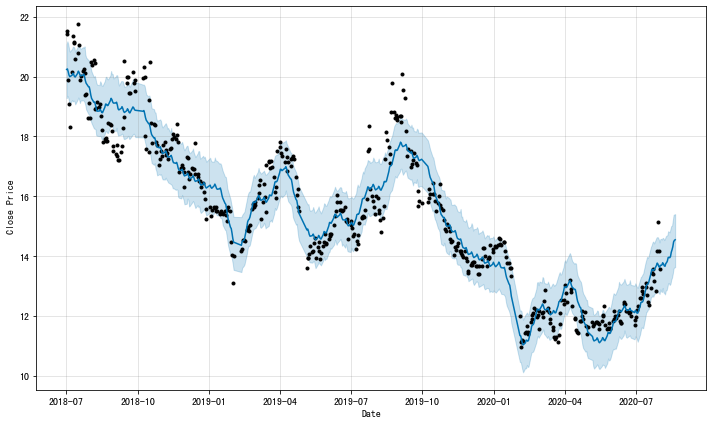

In [28]:
model.plot(forecast, xlabel = 'Date', ylabel = 'Close Price ¥')

<AxesSubplot:xlabel='Date'>

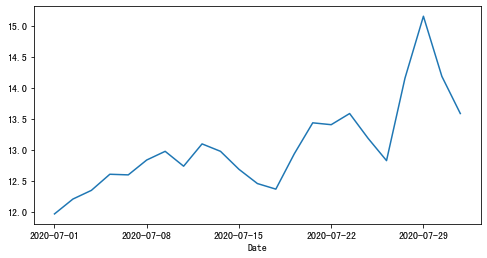

In [29]:
df['Close']['2020-07-01':'2020-08-01'].plot(figsize=(8,4))